<h3><b>Simulate The System Using Stochastic Simulation Algorithm (SSA) Method</b></h3>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time

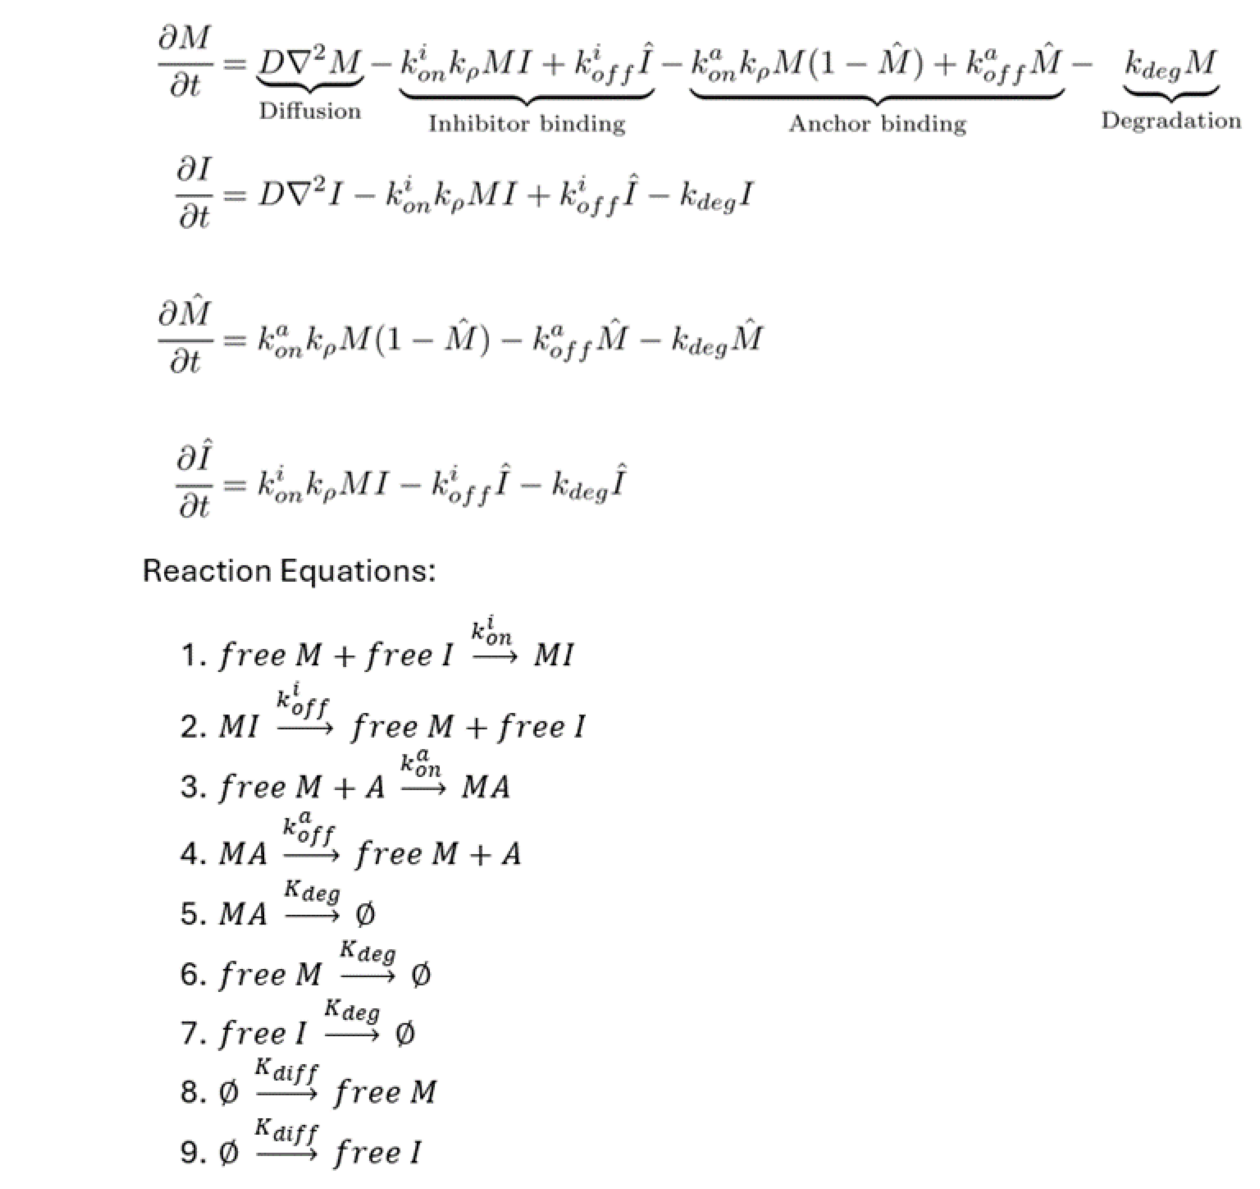

In [26]:
path = r"C:\Users\yda2\Desktop\study\master_project\equations1.png"
img = mpimg.imread(path)
plt.figure(figsize=(16, 20))
plt.imshow(img)
plt.axis('off') 
plt.show()

In [15]:
def initialize_species(fm_init, tm_init, fi_init, bi_init, start):
    """
    Args:
        - fm_init: initial concentration of free morphogen, integer or float
        - tm_init: initial concentration of trapped morphogen, integer or float
        - fi_init: initial concentration of free inhibitor, integer or float
        - bi_init: initial concentration of bound inhibitor, integer of float
        ### - fa_init: initial concentration of free anchor, integer of float
        - start: start time of the simulation, integer of float
       
    Returns:
        - species: a dictionary contains initialized time and species lists
    """
    time = [start]
    fm_conc = [fm_init]
    tm_conc = [tm_init]
    fi_conc = [fi_init]
    bi_conc = [bi_init]
    # fa_conc = [fa_init]

    species = {
        "Simulation Time": time,
        "Free Morphogen": fm_conc,
        "Trapped Morphogen": tm_conc,
        "Free Inhibitor": fi_conc,
        "Bound Inhibitor": bi_conc,
        # "Free Anchor": fa_conc
    }

    return species   

In [27]:
def compute_propensities(species, cons):
    """
    Args:
       - species: a dictionary contains initialized time and species lists
       - cons: a dictionary contains rate constants for all reactions in the system
               k_fm: free Morphogen rate constant, integer or float
               k_fi: free Inhibitor rate constant, integer or float
               k_ib_on: inhibitr binding rate constant (on), integer or float
               k_ib_off: inhibitor binding rate constant (off), integer or float
               k_ab_on: anchor binding rate constant (on), integer or float
               k_ab_off: anchor binding rate constant (off), integer or float
               kd_fm: free morphogen degradation rate constant, integer or float
               kd_tm: trapped morphogen degradation rate constan, integer or float
               kd_fi: free inhibitor degradation rate constant, integer or float
               kd_bi: bound inhibitor degradation rate constant, integer or float
               kp_a: effective anchor concentration rate constant, integer or float
               kp_i: effective inhibitor concentration rate constant, integer or float
               md: morphogen diffusion rate constant, integer or float
               id: inhibitor diffusion rate constant, integer or float
    Returns:
       - propensities: a dictionary contains calculated propensities of each reaction                                    
    """
    propensities = {}
    
    propensities["Morphogen_Inhibitor_binding"] = cons["k_ib_on"] * species["Free Morphogen"][-1] * species["Free Inhibitor"][-1]
    propensities["Morphogen_Inhibitor_unbinding"] = cons["k_ib_off"] * species["Bound Inhibitor"][-1]
    propensities["Morphogen_Anchor_binding"] = cons["k_ab_on"] * species["Free Morphogen"][-1] #  * species["Free Anchor"][-1]
    propensities["Morphogen_Anchor_unbinding"] = cons["k_ab_off"] * species["Trapped Morphogen"][-1]
    propensities["trapped_Morphogen_degraddation"] = cons["kd_tm"] * species["Trapped Morphogen"][-1]
    propensities["Morphogen_degradation"] = cons["kd_fm"]
    propensities["Morphogen_diffusion"] = cons["md"]
    propensities["Inhibitor_degradation"] = cons["kd_fi"]
    propensities["Inhibitor_diffusion"] = cons["id"]
    
    return propensities    

In [28]:
def compute_propensity_sum(propensities):
    """
    Computes sum of the propensities
    Args:
        - propensities: a dictionary contains propensity functions of the reactions.
            
    Returns:
        - propensity_sum: a float value, sum of the propensities.
    """
    propensity_sum = sum(propensities.values())

    return propensity_sum

In [29]:
def compute_tau(propensity_sum):

    """
    Computes  the time until the next reaction event occurs (tau)
    based on the sum of reaction propensities in the system.
    Args:
        - propensity_sum: a float value, sum of the propensities
    Returns:
        - tau: a float or an integer, calculated tau.
    """
    tau = np.random.exponential(scale=1 / (propensity_sum + 1e-15))

    return tau

In [44]:
def update(species, propensities, reaction, reactions, num_reaction, tau):
    """
    Args:
        - species: a dictionary in which the calculated concentrations of the species are stored
        - propensities: a dictionary contains the propensity values of the reactions
        - reaction: a float value that indicates which reaction is taking place
        - reactions: a list contains the name of all reactions in the system
        - num_reaction: an integer value that indicates the number of reaction in the system
        - tau: a float or an integer, calculated tau
            
    Returns:
        - species: a dictionary in which the calculated concentrations of the species are stored
    """
    species["Simulation Time"].append(species["Simulation Time"][-1] + tau)

    for i in range(num_reaction):
        
        reaction_name = reactions[i]
        
        if i == 0: # Morphogen_Inhibitor_binding
            
            if reaction <= propensities[reaction_name]:
                
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1] + 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1] - 1)
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1] - 1)
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                
        elif i == 1: # Morphogen_Inhibitor_unbinding
            
            if reaction <= propensities[reaction_name] and reaction > propensities[reactions[0]]:
                
                species["Free Morphogen"].append(species["Free Morphogen"][-1] + 1)
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1] + 1)
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1] - 1)
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                
        elif i == 2: # Morphogen_Anchor_binding
            
            if reaction <= propensities[reaction_name] and reaction > sum([propensities[reactions[0]], propensities[reactions[1]]]):
                
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1] + 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1] - 1)
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 3: # Morphogen_Anchor_unbinding
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]]
            ]):
                
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1] + 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1] - 1)
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 4:  # trapped_Morphogen_degraddation
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]],
                propensities[reactions[3]]
            ]):
                
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1] - 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1])
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 5: # Morphogen_degradation
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]],
                propensities[reactions[3]],
                propensities[reactions[4]]
            ]):
                
                species["Free Morphogen"].append(species["Free Morphogen"][-1] - 1)
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 6: # Morphogen_diffusion
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]],
                propensities[reactions[3]],
                propensities[reactions[4]],
                propensities[reactions[5]]
            ]):
                
                species["Free Morphogen"].append(species["Free Morphogen"][-1] + 1)
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 7: # Inhibitor_degradation
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]],
                propensities[reactions[3]],
                propensities[reactions[4]],
                propensities[reactions[5]],
                propensities[reactions[6]]
            ]):
                
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1] - 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1])
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
                
        elif i == 8: # Inhibitor_diffusion
            
            if reaction <= propensities[reaction_name] and reaction > sum([
                propensities[reactions[0]],
                propensities[reactions[1]],
                propensities[reactions[2]],
                propensities[reactions[3]],
                propensities[reactions[4]],
                propensities[reactions[5]],
                propensities[reactions[6]],
                propensities[reactions[7]]
            ]):
                
                species["Free Inhibitor"].append(species["Free Inhibitor"][-1] + 1)
                species["Free Morphogen"].append(species["Free Morphogen"][-1])
                species["Trapped Morphogen"].append(species["Trapped Morphogen"][-1])
                species["Bound Inhibitor"].append(species["Bound Inhibitor"][-1])
            
    return species    

In [45]:
def simulation(fm_init, tm_init, fi_init, bi_init, constants, start, stop, max_epochs):
    """
    Args:
        - fm_init: initial concentration of free morphogen, integer or float
        - tm_init: initial concentration of trapped morphogen, integer or float
        - fi_init: initial concentration of free inhibitor, integer or float
        - bi_init: initial concentration of bound inhibitor, integer of float
        ### - fa_init: initial concentration of free anchor, integer of float
        - constants: a dictionary contains rate constants for all reactions in the system
                     k_fm: free Morphogen rate constant, integer or float
                     k_fi: free Inhibitor rate constant, integer or float
                     k_sec_fm: free morphogen secretion rate, integer or float
                     k_sec_fi: free inhibitor secretion rate, integer or float
                     k_ib_on: inhibitr binding rate constant (on), integer or float
                     k_ib_off: inhibitor binding rate constant (off), integer or float
                     k_ab_on: anchor binding rate constant (on), integer or float
                     k_ab_off: anchor binding rate constant (off), integer or float
                     kd_fm: free morphogen degradation rate constant, integer or float
                     kd_tm: trapped morphogen degradation rate constan, integer or float
                     kd_fi: free inhibitor degradation rate constant, integer or float
                     kd_bi: bound inhibitor degradation rate constant, integer or float
                     kp: effective concentration rate constant, integer or float
                     md: morphogen diffusion rate constan, integer or float
                     id: inhibitor diffusion rate constant, integer or float
        - start: start time of the simulation, integer of float
        - stop: stop time of the simulation, integer or float
        - max_epochs: number of maximum simulation iterations, integer
    Returns:
        - species: a dictionary containing the simulation time and the concentrations of the species after the simulation
        - simulation_duration: a float that defines the simulation duration    
    """
    tic = time.time()
    
    species = initialize_species(
        fm_init=fm_init, 
        tm_init=tm_init, 
        fi_init=fi_init, 
        bi_init=bi_init,
        # fa_init=fa_init,
        start=start   
    )

    reactions = [
        "Morphogen_Inhibitor_binding", 
        "Morphogen_Inhibitor_unbinding", 
        "Morphogen_Anchor_binding",
        "Morphogen_Anchor_unbinding",
        "trapped_Morphogen_degraddation",
        "Morphogen_degradation",
        "Morphogen_diffusion",
        "Inhibitor_degradation",
        "Inhibitor_diffusion"
    ]

    step = 2
    while species["Simulation Time"][-1] <= stop and step < max_epochs:

        propensities = compute_propensities(
            species=species, 
            cons=constants
        )
        
        propensity_sum = compute_propensity_sum(
            propensities=propensities
        )
        tau = compute_tau(
            propensity_sum=propensity_sum
        )
        
        random_number = np.random.uniform(low=0, high=1)
        num_reactions = len(propensities)
        reaction = propensity_sum * random_number

        species = update(
            species=species,
            propensities=propensities, 
            reaction=reaction,
            reactions=reactions,
            num_reaction=num_reactions,
            tau=tau
        )
        step += 1
    toc = time.time()
    simulation_duration = {"Simulation Duration(second)": toc - tic}
        
    return (species, simulation_duration)    

dict_keys(['Simulation Time', 'Free Morphogen', 'Trapped Morphogen', 'Free Inhibitor', 'Bound Inhibitor'])
{'Simulation Duration(second)': 0.015050888061523438}


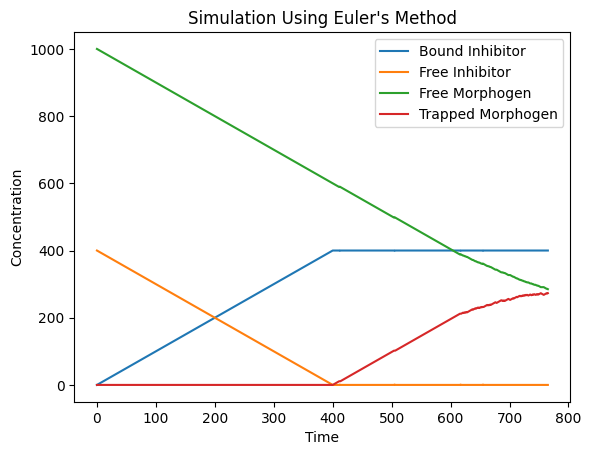

In [49]:
cons = {
    "k_fm": 0.01,
    "k_fi": 0.02,
    "k_sec_fm": .01,
    "k_sec_fi": 0.02,
    "k_ib_on": 0.01,
    "k_ib_off": 2e-4,
    "k_ab_on": 0.01,
    "k_ab_off": 2e-4,
    "kd_fm": 0.02, 
    "kd_tm": 0.02, 
    "kd_fi": 0.02, 
    "kd_bi": 0.02,
    "kp_a": 1e-07,
    "kp_i": 1e-07,
    "md": 0.01,
    "id": 0.01
}

test7 = simulation(1000, 0, 400, 0, cons, 0, 1000, 1000)
print(test7[0].keys())
print(test7[1])

plt.plot(test7[0]["Bound Inhibitor"], label="Bound Inhibitor")
plt.plot(test7[0]["Free Inhibitor"], label="Free Inhibitor")
plt.plot(test7[0]["Free Morphogen"], label="Free Morphogen")
plt.plot(test7[0]["Trapped Morphogen"], label="Trapped Morphogen")
plt.title("Simulation Using Euler's Method")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()